**-PREPARING ENVIRONMENT-**

In [ ]:
pip install --upgrade google-api-python-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 21.1 MB/s eta 0:00:00
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.160.0
    Uninstalling google-api-python-client-2.160.0:
      Successfully uninstalled google-api-python-client-2.160.0


In [ ]:
# Importing necessary libraries
import os
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**-BUILDING SCRAPER-**

In [ ]:
API_KEY = 'YOUR_API_KEY' # Please replace with your own API key for analysis
youtube = build('youtube', 'v3', developerKey=API_KEY)

In [ ]:
# Function: Get video data by video ID
def get_video_data(video_id):
  request = youtube.videos().list(
      part='snippet,statistics,contentDetails',
      id=video_id
  )
  response = request.execute()

  if 'items' in response:
    video_data = response['items'][0]
    title = video_data['snippet']['title']
    release_date = video_data['snippet']['publishedAt']
    view_count = video_data['statistics']['viewCount']
    like_count = video_data['statistics']['likeCount']
    comment_count = video_data['statistics']['commentCount']
    tags = video_data['snippet'].get('tags', [])
    vid_length = video_data['contentDetails']['duration']

    data = {
      'title': title,
      'release_date': release_date,
      'view_count': view_count,
      'like_count': like_count,
      'comment_count': comment_count,
      'tags': tags,
      'vid_length': vid_length
    }
    return data
  else:
    return None

In [ ]:
# Testing connection
video_id = 'tTVODRiVDCg'
video_data = get_video_data(video_id)

# Check if video_data is not None and has data
if video_data and any(video_data.values()):
    df = pd.DataFrame([video_data]) # Create a list of dict for single entry
    print(df)
else:
    print("No data found for the video or video not found.")

              title          release_date view_count like_count comment_count  \
0  UAT Cyber Ninjas  2025-03-06T22:04:28Z         60          3             0   

  tags vid_length  
0   []    PT1M30S  


Collecting all uploads from one channel

In [ ]:
import time

In [ ]:
# Function: get video data (view count, like count, comments, release date)
def get_video_data(video_id):
    request = youtube.videos().list(
        part="snippet,statistics,contentDetails",
        id=video_id
    )
    response = request.execute()

    if 'items' in response:
        video = response['items'][0]
        title = video['snippet']['title']
        release_date = video['snippet']['publishedAt']
        views = video['statistics'].get('viewCount', 'Not available')
        likes = video['statistics'].get('likeCount', 'Not available')
        comments = video['statistics'].get('commentCount', 'Not available')
        tags = video['snippet'].get('tags', 'Not available')
        vid_length = video['contentDetails']['duration']

        # Returning the data in a dictionary
        return {
            'video_id': video_id,
            'title': title,
            'release_date': release_date,
            'views': views,
            'likes': likes,
            'comments': comments,
            'tags': tags,
            'vid_length': vid_length
        }
    else:
        print(f"Video {video_id} not found")
        return None

In [ ]:
# Function: get all video IDs from a channel's uploads playlist
def get_video_ids_from_channel(channel_id):
    # First, fetch the uploads playlist ID
    request = youtube.channels().list(
        part="contentDetails",
        id=channel_id
    )
    response = request.execute()

    # Getting the playlist ID from the response
    uploads_playlist_id = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']

    # Fetching all video IDs in the uploads playlist
    video_ids = []
    next_page_token = None

    while True:
        playlist_request = youtube.playlistItems().list(
            part="snippet",
            playlistId=uploads_playlist_id,
            maxResults=50,  # Max allowed by YouTube
            pageToken=next_page_token
        )
        playlist_response = playlist_request.execute()

        # Collecting video IDs for this page of results
        for item in playlist_response['items']:
            video_ids.append(item['snippet']['resourceId']['videoId'])

        # Checking if there is another page of results
        next_page_token = playlist_response.get('nextPageToken')
        if not next_page_token:
            break

        # Delay to avoid rate limits (originally an issue)
        time.sleep(3)

    return video_ids

In [ ]:
# Function: Gather data for all videos in channel and store to csv file
def collect_video_data(channel_id):
    video_ids = get_video_ids_from_channel(channel_id)
    all_video_data = []

    for video_id in video_ids:
        video_data = get_video_data(video_id)
        if video_data:
            all_video_data.append(video_data)

    # assigning appended data to dataframe
    df = pd.DataFrame(all_video_data)

    # Convert the list of video data into a DataFrame, update to csv every 50 vids
    if len(all_video_data) % 50 == 0:
      df.to_csv('youtube_video_data.csv', index=False, mode='a')
    return df

**-COLLECTING DATA-**

In [ ]:
# Implementing the scraper
# UAT's channel ID
channel_id = 'Channel_ID' # Replace with channel ID
channel_df = collect_video_data(channel_id)

# Ensure the DataFrame is saved to the CSV file
channel_df.to_csv('youtube_data_UAT.csv', index=False, mode='w')  # mode='w' to overwrite

In [ ]:
df = pd.read_csv('/content/youtube_data_UAT.csv')
df.head()

,video_id,title,release_date,views,likes,comments,tags,vid_length
0,tTVODRiVDCg,UAT Cyber Ninjas,2025-03-06T22:04:28Z,60,3,0,Not available,PT1M30S
1,W5SA-6wphWA,2024 Valedictorian Tyler Widener,2025-02-26T18:01:39Z,32,1,0,Not available,PT16S
2,4FXI2GgEus8,Your Idea of Fun is tech,2025-02-26T17:59:15Z,452,8,0,Not available,PT4S
3,IfrdgzxlgFE,Looking for future UAT Students,2025-02-26T17:51:14Z,725,33,0,Not available,PT6S
4,a6lS9iEcr70,Check out University of Advancing Technology,2025-02-26T17:49:12Z,455,10,0,Not available,PT6S


In [ ]:
# Checking size of dataset
df.shape

(289, 8)

There are 289 videos within the dataset, with 8 unique features present.

In [ ]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   video_id      289 non-null    object
 1   title         289 non-null    object
 2   release_date  289 non-null    object
 3   views         289 non-null    object
 4   likes         289 non-null    int64 
 5   comments      289 non-null    int64 
 6   tags          289 non-null    object
 7   vid_length    289 non-null    object
dtypes: int64(2), object(6)
memory usage: 18.2+ KB
None
             likes    comments
count   289.000000  289.000000
mean     28.868512    1.519031
std     124.481327    4.859179
min       0.000000    0.000000
25%       2.000000    0.000000
50%       5.000000    0.000000
75%      13.000000    1.000000
max    1817.000000   40.000000


EDA shows that there are no null values in the data. However, there are three numeric columns which must be typecasted as such, as they are currently objects:

release_date (to datetime)

views (to int64)

vid_length (to viewable object)

**-PREPARING DATA-**

In [ ]:
# Typecasting to proper dtypes
df['title'] = df['title'].astype(str)
df['release_date'] = pd.to_datetime(df['release_date'])
df['views'] = pd.to_numeric(df['views'], errors='coerce')

In [ ]:
# Typecasting to proper dtypes
df['title'] = df['title'].astype(str)
df['release_date'] = pd.to_datetime(df['release_date'])
df['views'] = pd.to_numeric(df['views'], errors='coerce')
# Fill NaN values with 0 before converting to int64
df['views'] = df['views'].fillna(0).astype('int64') # Fill NaN with 0 and then convert

In [ ]:
# Converting video length to readable format
import re

def convert_duration(duration):
    # Match hours, minutes, and seconds in the format PT#H#M#S
    pattern = re.compile(r"PT(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?")
    match = pattern.match(duration)

    if not match:
        return None  # If the format is incorrect or doesn't match

    # Extract hours, minutes, and seconds from the match (or 0 if not present)
    hours = int(match.group(1) or 0)
    minutes = int(match.group(2) or 0)
    seconds = int(match.group(3) or 0)

    # Return the time in hh:mm:ss format
    return f"{hours:02}:{minutes:02}:{seconds:02}"

In [ ]:
df['vid_length'] = df['vid_length'].apply(convert_duration)

In [ ]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   video_id      289 non-null    object             
 1   title         289 non-null    object             
 2   release_date  289 non-null    datetime64[ns, UTC]
 3   views         289 non-null    int64              
 4   likes         289 non-null    int64              
 5   comments      289 non-null    int64              
 6   tags          289 non-null    object             
 7   vid_length    288 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(3), object(4)
memory usage: 18.2+ KB
None
              views        likes    comments
count  2.890000e+02   289.000000  289.000000
mean   1.543899e+04    28.868512    1.519031
std    1.487355e+05   124.481327    4.859179
min    0.000000e+00     0.000000    0.000000
25%    8.800000e+01     2.000000    0.000

There are now nulls within the dataset. I will fill them with the mean per best practicess.

In [ ]:
# Filling nulls in numeric columns
for col in ['views', 'likes', 'comments']:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Ensuring numeric
df.fillna(df[['views', 'likes', 'comments']].mean(), inplace=True)  # Filling NaNs with the mean of numeric cols

In [ ]:
# Filling nulls in categorical columns
df['vid_length'] = df['vid_length'].fillna('Unknown')

In [ ]:
df.head()

,video_id,title,release_date,views,likes,comments,tags,vid_length
0,tTVODRiVDCg,UAT Cyber Ninjas,2025-03-06 22:04:28+00:00,60,3,0,Not available,00:01:30
1,W5SA-6wphWA,2024 Valedictorian Tyler Widener,2025-02-26 18:01:39+00:00,32,1,0,Not available,00:00:16
2,4FXI2GgEus8,Your Idea of Fun is tech,2025-02-26 17:59:15+00:00,452,8,0,Not available,00:00:04
3,IfrdgzxlgFE,Looking for future UAT Students,2025-02-26 17:51:14+00:00,725,33,0,Not available,00:00:06
4,a6lS9iEcr70,Check out University of Advancing Technology,2025-02-26 17:49:12+00:00,455,10,0,Not available,00:00:06


In [ ]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   video_id      289 non-null    object             
 1   title         289 non-null    object             
 2   release_date  289 non-null    datetime64[ns, UTC]
 3   views         289 non-null    int64              
 4   likes         289 non-null    int64              
 5   comments      289 non-null    int64              
 6   tags          289 non-null    object             
 7   vid_length    289 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(3), object(4)
memory usage: 18.2+ KB
None
              views        likes    comments
count  2.890000e+02   289.000000  289.000000
mean   1.543899e+04    28.868512    1.519031
std    1.487355e+05   124.481327    4.859179
min    0.000000e+00     0.000000    0.000000
25%    8.800000e+01     2.000000    0.000

In [ ]:
# Writing cleaned data to new file
df.to_csv('youtube_data_UAT_clean.csv', index=False)

**-EXPLORING DATA-**

Visualizing numerical data using Seaborn

In [ ]:
numeric_df = df[['views', 'likes', 'comments']]
numeric_df.describe()

,views,likes,comments
count,2.890000e+02,289.000000,289.000000
mean,1.543899e+04,28.868512,1.519031
std,1.487355e+05,124.481327,4.859179
min,0.000000e+00,0.000000,0.000000
25%,8.800000e+01,2.000000,0.000000
50%,2.510000e+02,5.000000,0.000000
75%,1.534000e+03,13.000000,1.000000
max,2.496244e+06,1817.000000,40.000000


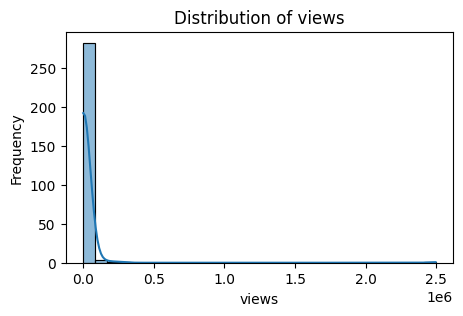

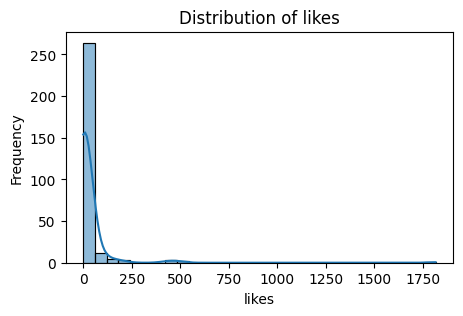

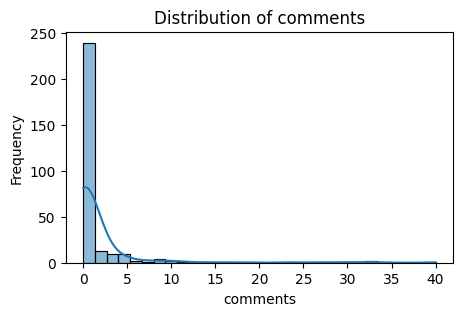

In [ ]:
for feature in numeric_df:
  plt.figure(figsize=(5, 3))
  sns.histplot(numeric_df[feature], bins=30, kde=True)
  plt.title(f'Distribution of {feature}')
  plt.xlabel(feature)
  plt.ylabel('Frequency')
  plt.show()

The visualizations show that most of the data is clustered near the bottom of the dataset, but extends far to the right. This extreme skew makes the data hard to read. I will scale it with a logarithm to rectify this.

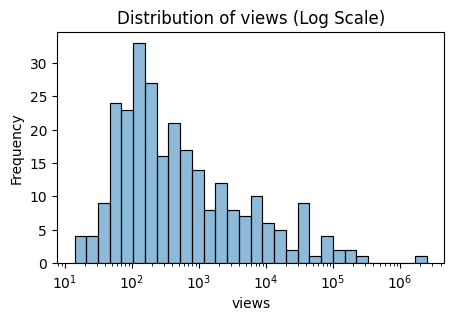

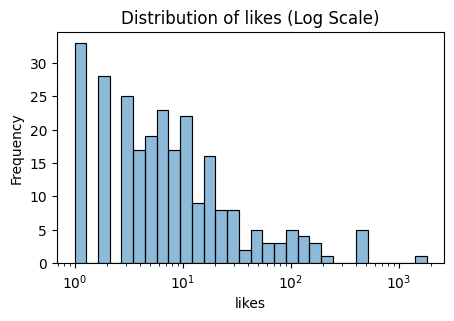

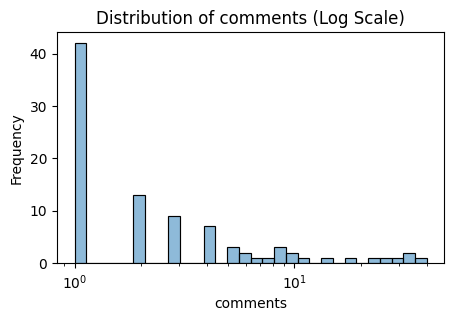

In [ ]:
for feature in numeric_df:
  plt.figure(figsize=(5, 3))
  sns.histplot(numeric_df[feature], bins=30, kde=True, log_scale=True)
  plt.title(f'Distribution of {feature} (Log Scale)')
  plt.xlabel(feature)
  plt.ylabel('Frequency')
  plt.show()

**Views:**

The graphs show that most videos have view counts within the tens to the thousands. The logarithm scale shows most of the data lies between 10^1 and 10^3.

**Likes:**

The graphs show that most videos have a like count under 10, although there are outliers with likes in the thousands.

**Comments:**

The graphs show that most videos have a comment count under 10.

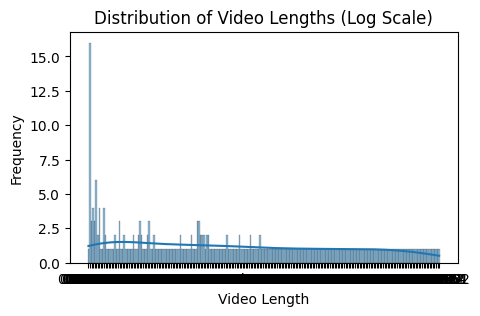

In [ ]:
# Plotting distribution of video lengths
plt.figure(figsize=(5, 3))
sns.histplot(df['vid_length'], bins=10, kde=True, log_scale=True)
plt.title('Distribution of Video Lengths (Log Scale)')
plt.xlabel('Video Length')
plt.ylabel('Frequency')
plt.show()

This format is a bit hard to read, even with bins. I'll convert the format of video lengths to seconds to rectify this.

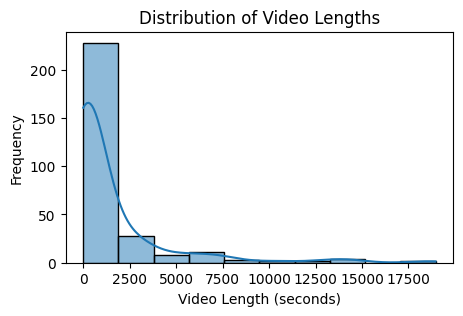

In [ ]:
# Changing format of video lengths
def convert_duration_to_seconds(duration):
    # Checking if the duration is 'Unknown' - one value as such in dataset
    if duration == 'Unknown':
        return None
    else:
        hours, minutes, seconds = map(int, duration.split(':'))
        total_seconds = (hours * 3600) + (minutes * 60) + seconds
        return total_seconds

vid_length_seconds = df['vid_length'].apply(convert_duration_to_seconds)

# Plotting distribution of video lengths, excluding 'Unknown'
plt.figure(figsize=(5, 3))
# Excluding 'Unknown' values
sns.histplot(vid_length_seconds.dropna(), bins=10, kde=True)
plt.title('Distribution of Video Lengths')
plt.xlabel('Video Length (seconds)')
plt.ylabel('Frequency')
plt.show()

The videos range from 0 to 17,500 seconds. In other words, the videos range from a few seconds to nearly 5 hours. However, the graph is hard to read in this format, and so I will convert it to log scale for readability.

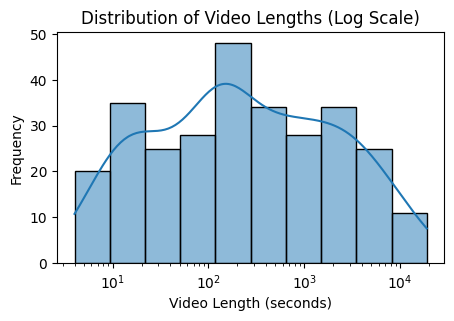

In [ ]:
vid_length_seconds = df['vid_length'].apply(convert_duration_to_seconds)

# Plotting distribution of video lengths, excluding 'Unknown'
plt.figure(figsize=(5, 3))
# Excluding 'Unknown' values
sns.histplot(vid_length_seconds.dropna(), bins=10, kde=True, log_scale=True)
plt.title('Distribution of Video Lengths (Log Scale)')
plt.xlabel('Video Length (seconds)')
plt.ylabel('Frequency')
plt.show()

The graphs show that the range of video lengths is quite large. While most videos are shorter (The channel has many YouTube Shorts, as well as short minute-long interviews), there are some that are much longer. Again, the range is from a few seconds to nearly 5 hours.

Exploring categorical data

In [ ]:
df.sample(10)

,video_id,title,release_date,views,likes,comments,tags,vid_length
96,pBohAdKG0_8,"Game Design, Game Animation and Game Programmi...",2021-12-01 00:11:24+00:00,551,20,0,Not available,00:00:17
88,-sh0r4bnpkw,CES 2022: AI Processor,2022-01-06 18:25:37+00:00,199,11,0,"['CES', 'new tech', 'innovation', 'new technol...",00:00:04
262,aQYc6AWi9g4,UAT fig 2012,2012-11-03 19:01:12+00:00,187,2,1,"['UAT', 'fig', '2012']",00:03:32
159,h33CL7_i9DI,"AI, AR, VR and Robotics Majors at University o...",2018-12-09 02:20:39+00:00,155433,11,0,Not available,00:00:16
188,wjpw-F7uB5E,University of Advancing Technology President J...,2017-03-27 22:02:07+00:00,3907,50,1,"['university', 'college', 'technology', 'tech'...",00:02:11
160,7Dos0rmGAnc,University of Advancing Technology 360º Campus...,2018-11-20 19:37:51+00:00,25654,189,6,"['virtual reality', 'vr video', 'higher educat...",00:04:41
270,VTxOcYSJcU4,Evan Sprague: A Look at Intel Studios,2012-03-24 01:04:38+00:00,254,0,0,"['intel', 'studios', 'evan', 'sprague']",00:38:59
48,GX9rv0B6Yq4,Happy Holidays from UAT!,2023-12-07 16:38:01+00:00,158,7,0,Not available,00:00:13
175,GZNbmYUQa8s,Digital Video & Theater Professor Sharon Bolma...,2018-03-19 16:23:43+00:00,2845,16,1,"['higher education', 'private university', 'te...",00:02:29
279,2unUn-ISad4,Jeremy Leung - Hackerspace- Awakening America'...,2011-08-19 22:01:05+00:00,152,4,1,"['Jeremy', 'Leung', 'Hackerspace', 'Awakening'...",00:39:02


In [ ]:
import re

total_tags = []

for tags in df['tags']:
  if isinstance(tags, list):
    total_tags.extend(tags)  # Extending directly for lists
  elif isinstance(tags, str):
    # Removing brackets and split by commas for string
    # Use regex to remove brackets
    cleaned_tags = re.sub(r"[\[\]']", "", tags)
    total_tags.extend([tag.strip() for tag in cleaned_tags.split(',')])

# Counting frequency of each tag
most_frequent_tags = pd.Series(total_tags).value_counts()

# Obtaining top 10 most frequent tags
print(most_frequent_tags.head(10))

Not available                         150
UAT                                    44
university of advancing technology     21
technology                             21
#hoa                                   18
Hangouts On Air                        18
#hangoutsonair                         18
college                                16
uat                                    16
innovation                             15
Name: count, dtype: int64


Some of the most common tags used include 'UAT', 'technology', 'Hangouts on Air', and 'college'.

In [ ]:
# converting length to seconds for analysis
vid_length_seconds = df['vid_length'].apply(convert_duration_to_seconds)

In [ ]:
numeric_df = df[['views', 'likes', 'comments','vid_length']]
numeric_df['vid_length'] = vid_length_seconds
numeric_df.describe()

<ipython-input-41-a1013e76c003>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df['vid_length'] = vid_length_seconds


,views,likes,comments,vid_length
count,2.890000e+02,289.000000,289.000000,288.000000
mean,1.543899e+04,28.868512,1.519031,1479.531250
std,1.487355e+05,124.481327,4.859179,2993.910852
min,0.000000e+00,0.000000,0.000000,4.000000
25%,8.800000e+01,2.000000,0.000000,38.750000
50%,2.510000e+02,5.000000,0.000000,194.000000
75%,1.534000e+03,13.000000,1.000000,1226.500000
max,2.496244e+06,1817.000000,40.000000,18955.000000


**-Analyzing Patterns-**

In [ ]:
numeric_df.corr()

,views,likes,comments,vid_length
views,1.000000,0.861563,0.486754,-0.045219
likes,0.861563,1.000000,0.698212,-0.045405
comments,0.486754,0.698212,1.000000,0.024040
vid_length,-0.045219,-0.045405,0.024040,1.000000


<Axes: >

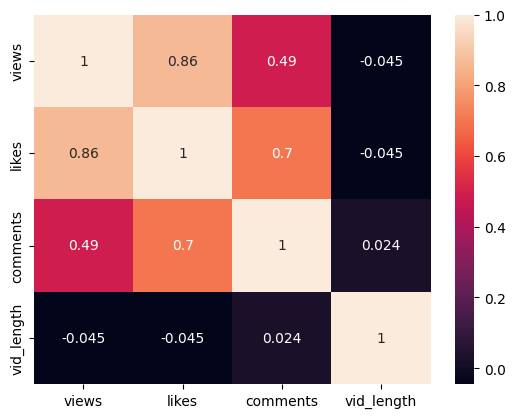

In [ ]:
sns.heatmap(numeric_df.corr(), annot=True)

The heatmap demonstrates that likes and views have a rather strong positive correlation. Likes and comments also have a strong correlation. Views and comments share a medium positive correlation.

Video length has an incredibly low correlation with all other features. I suspect this is due to the wide range of values. To rectify this, I will seperate video lengths into categories.

In [ ]:
# Splitting time into categories for analysis
# <60sec - Shorts (Under a minute)
# <240sec - "Short" (Under 4 minutes)
# <1200sec - Average (4-20mins)
# >1200sec - Long (Over 20 minutes)
bins = [60, 240, 1200]

In [ ]:
time_df = df.copy()

# Convert 'vid_length' to seconds before applying pd.cut
time_df['vid_length_seconds'] = time_df['vid_length'].apply(convert_duration_to_seconds)

# Now apply pd.cut to the numeric 'vid_length_seconds' column
# Added a label to match the number of bins and included right=False to follow the original intent
time_df['vid_length'] = pd.cut(
    time_df['vid_length_seconds'],
    bins=[0, 60, 240, 1200, float('inf')],  # Added 0 and inf for boundaries
    labels=['Shorts', 'Short', 'Average', 'Long'],  # Added 'Short' label
    # Include the lowest value in the first bin
    include_lowest=True,
    # Specify right=False to make bins (0, 60], (60, 240], etc.
    right=False
)

In [ ]:
numeric_time_df = time_df[['views', 'likes', 'comments','vid_length']]
# Convert 'vid_length' to a numerical representation for correlation calculation
numeric_time_df['vid_length_numeric'] = numeric_time_df['vid_length'].cat.codes
# Calculate correlation with the numerical representation
correlation = numeric_time_df[['views', 'likes', 'comments', 'vid_length_numeric']].corr()
print(correlation)

                       views     likes  comments  vid_length_numeric
views               1.000000  0.861563  0.486754           -0.049834
likes               0.861563  1.000000  0.698212           -0.009106
comments            0.486754  0.698212  1.000000            0.126887
vid_length_numeric -0.049834 -0.009106  0.126887            1.000000


<ipython-input-26-aacbace71338>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_time_df['vid_length_numeric'] = numeric_time_df['vid_length'].cat.codes


<Axes: >

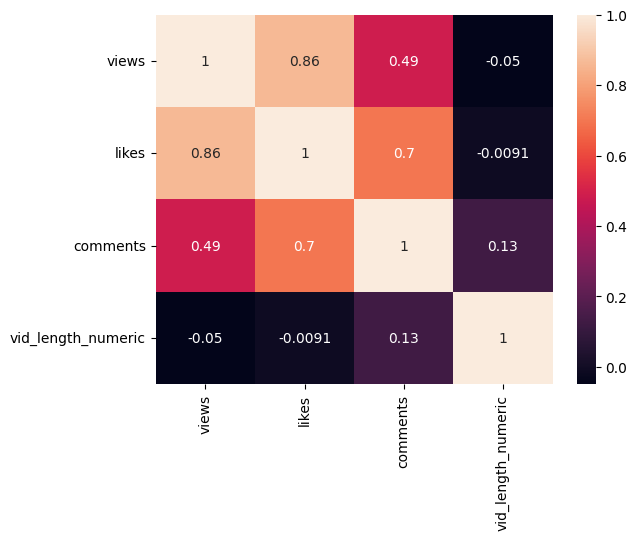

In [ ]:
sns.heatmap(numeric_time_df[['views', 'likes', 'comments', 'vid_length_numeric']].corr(), annot=True)

In [ ]:
# Splitting the time into categories
shorts_df = time_df[time_df['vid_length'] == 'Shorts']
short_df = time_df[time_df['vid_length'] == 'Short']
average_df = time_df[time_df['vid_length'] == 'Average']
long_df = time_df[time_df['vid_length'] == 'Long']

In [ ]:
# Function to create heatmap with encoded video length
def create_heatmap_with_encoded_vid_length(df, category_name):
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Convert 'vid_length' to numerical representation using label encoding
    df_copy['vid_length_numeric'] = pd.Categorical(df_copy['vid_length']).codes

    # Calculate correlation with the numerical representation
    correlation = df_copy[['views', 'likes', 'comments', 'vid_length_numeric']].corr()

    # Create and display the heatmap
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    sns.heatmap(correlation, annot=True, cmap='coolwarm')  # Choose a colormap
    plt.title(f'Correlation Heatmap for {category_name} Videos')
    plt.show()

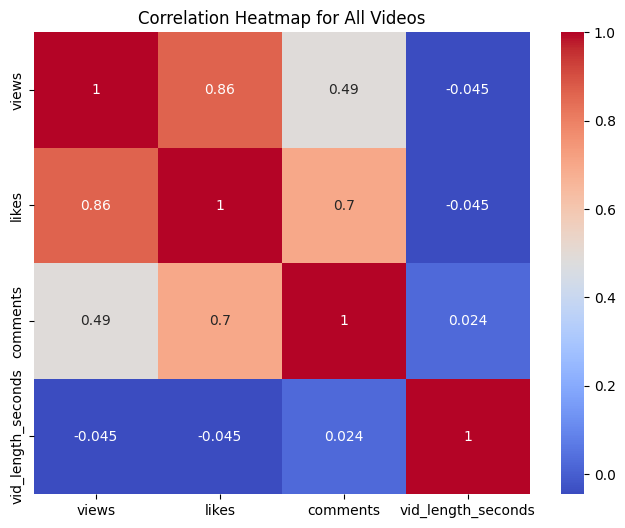

In [ ]:
# Convert 'vid_length_category' to numerical representation for correlation calculation
time_df['vid_length_numeric'] = pd.Categorical(time_df['vid_length']).codes # changed to use the categorical column

# Calculate correlation with the numerical representation
correlation = time_df[['views', 'likes', 'comments', 'vid_length_seconds']].corr()

# Create and display the heatmap
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
sns.heatmap(correlation, annot=True, cmap='coolwarm')  # Choose a colormap
plt.title('Correlation Heatmap for All Videos')
plt.show()

                       views     likes  comments  vid_length_seconds
views               1.000000  0.054630  0.149357           -0.007030
likes               0.054630  1.000000  0.093323            0.042565
comments            0.149357  0.093323  1.000000            0.259730
vid_length_seconds -0.007030  0.042565  0.259730            1.000000


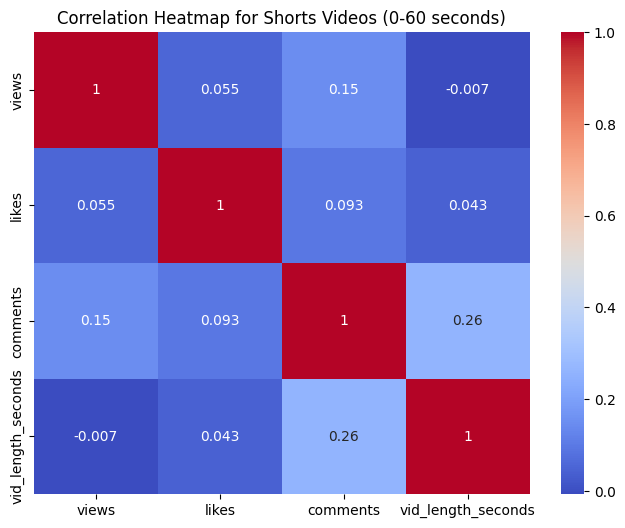

In [ ]:
shorts_correlation = shorts_df[['views', 'likes', 'comments', 'vid_length_seconds']].corr()
print(shorts_correlation)

plt.figure(figsize=(8, 6))
sns.heatmap(shorts_correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Shorts Videos (0-60 seconds)')
plt.show()

                       views     likes  comments  vid_length_seconds
views               1.000000  0.976881  0.769190           -0.136520
likes               0.976881  1.000000  0.820108           -0.147361
comments            0.769190  0.820108  1.000000            0.017682
vid_length_seconds -0.136520 -0.147361  0.017682            1.000000


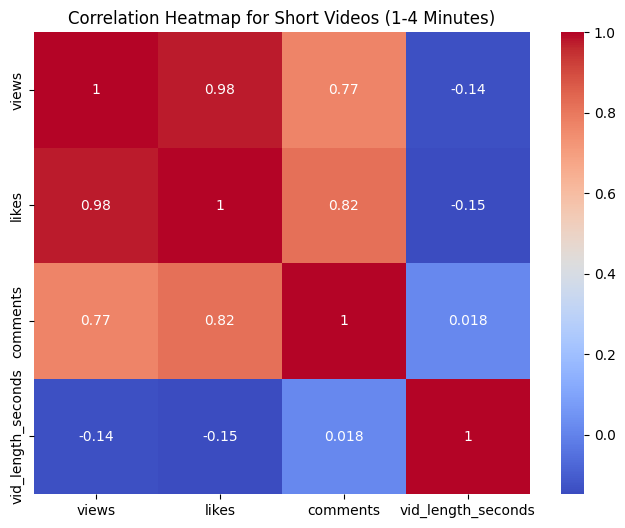

In [ ]:
short_correlation = short_df[['views', 'likes', 'comments', 'vid_length_seconds']].corr()
print(short_correlation)

plt.figure(figsize=(8, 6))
sns.heatmap(short_correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Short Videos (1-4 Minutes)')
plt.show()

                       views     likes  comments  vid_length_seconds
views               1.000000  0.846707  0.766301           -0.162288
likes               0.846707  1.000000  0.836937           -0.056144
comments            0.766301  0.836937  1.000000           -0.094669
vid_length_seconds -0.162288 -0.056144 -0.094669            1.000000


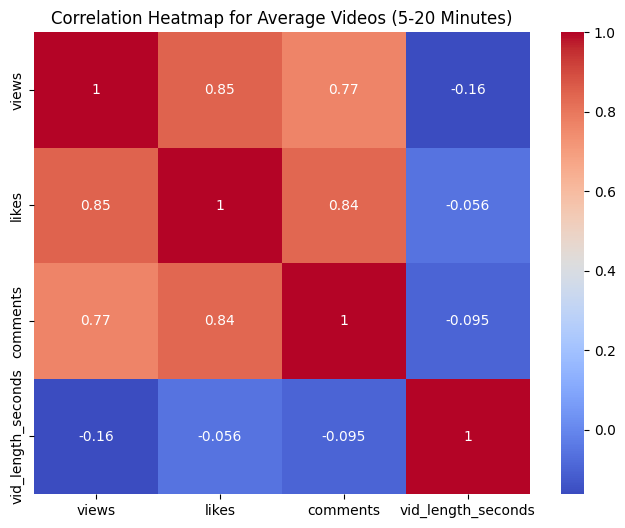

In [ ]:
average_correlation = average_df[['views', 'likes', 'comments', 'vid_length_seconds']].corr()
print(average_correlation)

plt.figure(figsize=(8, 6))
sns.heatmap(average_correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Average Videos (5-20 Minutes)')
plt.show()

                       views     likes  comments  vid_length_seconds
views               1.000000  0.773680  0.884407            0.071966
likes               0.773680  1.000000  0.882676            0.041381
comments            0.884407  0.882676  1.000000            0.014058
vid_length_seconds  0.071966  0.041381  0.014058            1.000000


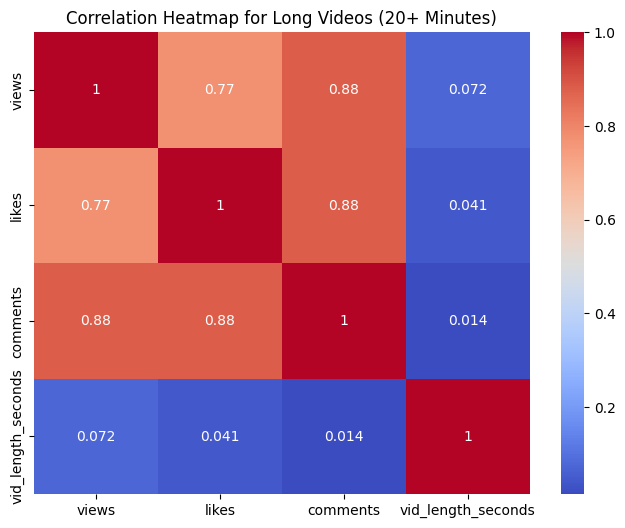

In [ ]:
long_correlation = long_df[['views', 'likes', 'comments', 'vid_length_seconds']].corr()
print(long_correlation)

plt.figure(figsize=(8, 6))
sns.heatmap(long_correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Long Videos (20+ Minutes)')
plt.show()

Based on the heatmaps, some general patterns begin to appear:

For youtube Shorts, most attributes have very low correlation. I suspect this is typical for short-form content, but will research further.

For short videos (1-4 minutes, NOT to be confused with YouTube Shorts), views share a very strong positive correlation with likes and a similarly strong correlation with comments. Likes and comments also share a positive correlation, although it is weaker.

For videos of average length (4-20 minutes), views again share a strong correlation with both likes and comments. Likes and comments share a similar strength of correlation.

For long videos (over 20 minutes), views again correlate with both likes and comments. Likes and comments share a strong correlation as well.